## **Face detection**
Task is to predict the boundaries(mask) around the face in a given image.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Change current working directory to project folder (1 mark)**

In [0]:
import os
os.chdir('/content/gdrive/My Drive/Akash')
path = '.'

### **Load the "images.npy" file (4 marks)**

In [0]:
import numpy as np
import tensorflow as tf
import keras   
import pandas as pd
import matplotlib.pyplot as plt
print("Numpy Version is ", np.__version__)


Numpy Version is  1.17.5


In [0]:
print(tf.__version__)

1.15.0


In [0]:
data = np.load('images.npy', allow_pickle=True)


In [0]:
data.shape

(409, 2)

### **Check one sample from the loaded "images.npy" file (4 marks)**

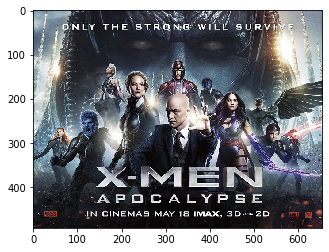

In [0]:
from matplotlib import pyplot as plt
plt.imshow(data[408][0])
plt.show()

### **Set image dimensions (2 marks)**

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### **Create features and labels**
Here feature is the image

*   **The label is the mask** 

*   **Images will be stored in "X_train" array**
*   **Masks will be stored in "masks" array** 









In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### **Print the shape of X_train and mask array  (1 mark)**

In [0]:
X_train.shape

(409, 224, 224, 3)

In [0]:
masks.shape

(409, 224, 224)

**Print a sample image and image array**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

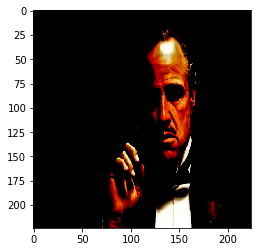

In [0]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

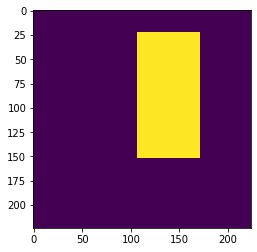

In [0]:
pyplot.imshow(masks[n])

## **Create the model (10 marks)**


*   **Add MobileNet as model with below parameter values**

*   **input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3**
*   **include_top: False**


*   **alpha : 1.0**
*   **Weights: Imagenet**

###    **Add UNET architecture layers** 
*   This is the trickiest part of the project, you need to research and implement it correctly



In [0]:
from keras.applications import MobileNet
from keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from keras.models import Model
import math
import cv2
import csv

from keras.applications.mobilenet import preprocess_input
from keras.utils import Sequence
from keras.optimizers import Adam
from keras.callbacks import csv
from keras.losses import binary_crossentropy


def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),alpha=1.0, include_top=False, weights='imagenet')

    for layer in model.layers:
        layer.trainable = trainable

    B1=model.get_layer("conv_pw_1_relu").output 
    B2=model.get_layer("conv_pw_3_relu").output 
    B3=model.get_layer("conv_pw_5_relu").output 
    B4=model.get_layer("conv_pw_11_relu").output 
    B5=model.get_layer("conv_pw_13_relu").output 

    x = Concatenate()([UpSampling2D()(B5),B4]) #14x14
    x = Concatenate()([UpSampling2D()(x),B3])  #28x28
    x = Concatenate()([UpSampling2D()(x),B2])  #56x56
    x = Concatenate()([UpSampling2D()(x),B1])  #112x112
    x = UpSampling2D()(x) #224x224

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [0]:
model = create_model()

model.summary()



Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_25[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
___________________________________________________________________________________________

## **Define dice coefficient function (5 marks)**
Create a function to calculate dice coefficient

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
from keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
# compile model
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coefficient])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
stop = EarlyStopping(monitor='loss', min_delta=0, patience=5, mode="min")

In [0]:
EPOCH = 20
BATCH_SIZE = 1
PATIENCE = 10
THREADS = 1
model.fit(x=X_train,
          y=masks,
          epochs=20,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint, stop],
          workers=THREADS,
          use_multiprocessing=False,
          verbose=1
          )

Epoch 1/20
409/409 [==============================] - 294s 720ms/step - loss: 1.1248 - dice_coefficient: 0.4870
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


409/409 [==============================] - 295s 721ms/step - loss: 1.0941 - dice_coefficient: 0.4997
Epoch 3/20
409/409 [==============================] - 294s 718ms/step - loss: 1.0668 - dice_coefficient: 0.5094
Epoch 4/20
409/409 [==============================] - 294s 718ms/step - loss: 1.0550 - dice_coefficient: 0.5157
Epoch 5/20
409/409 [==============================] - 294s 718ms/step - loss: 1.0374 - dice_coefficient: 0.5214
Epoch 6/20
409/409 [==============================] - 294s 719ms/step - loss: 1.0225 - dice_coefficient: 0.5270
Epoch 7/20
409/409 [==============================] - 294s 720ms/step - loss: 1.0143 - dice_coefficient: 0.5299
Epoch 8/20
409/409 [==============================] - 293s 717ms/step - loss: 1.0024 - dice_coefficient: 0.5342
Epoch 9/20
409/409 [==============================] - 293s 716ms/step - loss: 0.9959 - dice_coefficient: 0.5368
Epoch 10/20
409/409 [==============================] - 294s 718ms/step - loss: 0.9883 - dice_coefficient: 0.5388
Ep

## **Get the predicted mask for a sample image (5 marks)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


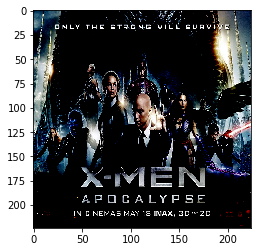

In [0]:
n = 408
sample_image = X_train[n]

plt.imshow(sample_image)
img = np.expand_dims(sample_image, axis=0)
out= model.predict(img)

#### Add your code here ####

In [0]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


### **Impose the mask on the image (5 marks)**

ValueError: ignored

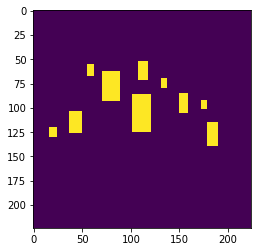

In [0]:
# evaluate loaded model on test data
Final = masks[408]
plt.imshow(Final)
img = np.expand_dims(Final, axis=0)
img = np.expand_dims(Final, axis=0)
predict = model.predict(img)